<a href="https://colab.research.google.com/github/habibarezq/ML-Assignments-25/blob/main/Assignment-2/notebooks/linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [4]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader ## to feed the data into the model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath("../"))
from src.logisitc_manual import LogisticRegression
from src.softmax_manual import SoftmaxRegression

# 1. Data Preparation

### Required Preprocessing and Transformations

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224)
])

Load Training and test data

In [24]:
dataset=datasets.MNIST(root="./data", download=True, train=True, transform=transform)
test_data=datasets.MNIST(root="./data", download=True, train=False, transform=transform)


100%|██████████| 9.91M/9.91M [00:04<00:00, 2.34MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 211kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


Extract data and labels

In [7]:
X= dataset.data.float() /255.0
y=dataset.targets

print(f"Full training data shape: {X.shape}")
print(f"Full training labels shape: {y.shape}")
print(f"Pixel value range: [{X.min():.2f}, {X.max():.2f}]")

Full training data shape: torch.Size([60000, 28, 28])
Full training labels shape: torch.Size([60000])
Pixel value range: [0.00, 1.00]


### Data Filtering

In [8]:
# Filter first: only digits 0 and 1 from the whole dataset
mask_train = (y == 0) | (y == 1)
X_binary = X[mask_train]
y_binary = y[mask_train]

### Data Splitting



In [9]:
# For Logisitic Regression
X_train_bin, X_temp_bin, y_train_bin, y_temp_bin = train_test_split(
    X_binary, y_binary, test_size=0.4, stratify=y_binary, random_state=42
)
X_val_bin, X_test_bin, y_val_bin, y_test_bin = train_test_split(
    X_temp_bin, y_temp_bin, test_size=0.5, stratify=y_temp_bin, random_state=42
)

# For softmax regression
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

### Flatten Images

In [10]:
X_train_flat_bin = X_train_bin.reshape(-1, 28*28)
X_val_flat_bin = X_val_bin.reshape(-1, 28*28)
X_test_flat_bin = X_test_bin.reshape(-1, 28*28)

# for softmax regression
X_train_flat = X_train.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

### Create Dataloaders

In [11]:
train_loader = DataLoader(
    TensorDataset(X_train_flat_bin, y_train_bin.float()),
    batch_size=32,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_flat_bin, y_val_bin.float()),
    batch_size=32,
    shuffle=False
)
test_loader = DataLoader(
    TensorDataset(X_test_flat_bin, y_test_bin.float()),
    batch_size=32,
    shuffle=False
)

# for softmax regression
train_loader_soft = DataLoader(
    TensorDataset(X_train_flat, y_train.float()),
    batch_size=32,
    shuffle=True
)
val_loader_soft = DataLoader(
    TensorDataset(X_val_flat, y_val.float()),
    batch_size=32,
    shuffle=False
)
test_loader_soft = DataLoader(
    TensorDataset(X_test_flat, y_test.float()),
    batch_size=32,
    shuffle=False
)


# 2. Logisitic Regression Implementation

#### Train model


In [12]:
n_features = 28 * 28
model = LogisticRegression(input_dim=n_features, learning_rate=0.01, max_epochs=100)
model.fit(train_loader, val_loader)

Epoch 10/100 - Train Loss: 0.0132, Train Acc: 0.9980 - Val Loss: 0.0143, Val Acc: 0.9973
Epoch 20/100 - Train Loss: 0.0090, Train Acc: 0.9980 - Val Loss: 0.0101, Val Acc: 0.9973
Epoch 30/100 - Train Loss: 0.0074, Train Acc: 0.9983 - Val Loss: 0.0084, Val Acc: 0.9980
Epoch 40/100 - Train Loss: 0.0065, Train Acc: 0.9986 - Val Loss: 0.0075, Val Acc: 0.9980
Epoch 50/100 - Train Loss: 0.0059, Train Acc: 0.9988 - Val Loss: 0.0069, Val Acc: 0.9980
Epoch 60/100 - Train Loss: 0.0054, Train Acc: 0.9988 - Val Loss: 0.0065, Val Acc: 0.9980
Epoch 70/100 - Train Loss: 0.0051, Train Acc: 0.9988 - Val Loss: 0.0061, Val Acc: 0.9980
Epoch 80/100 - Train Loss: 0.0048, Train Acc: 0.9988 - Val Loss: 0.0059, Val Acc: 0.9980
Epoch 90/100 - Train Loss: 0.0046, Train Acc: 0.9988 - Val Loss: 0.0057, Val Acc: 0.9980
Epoch 100/100 - Train Loss: 0.0044, Train Acc: 0.9988 - Val Loss: 0.0055, Val Acc: 0.9980


### Visualization

 ## Loss Curves & Accuracy Curve

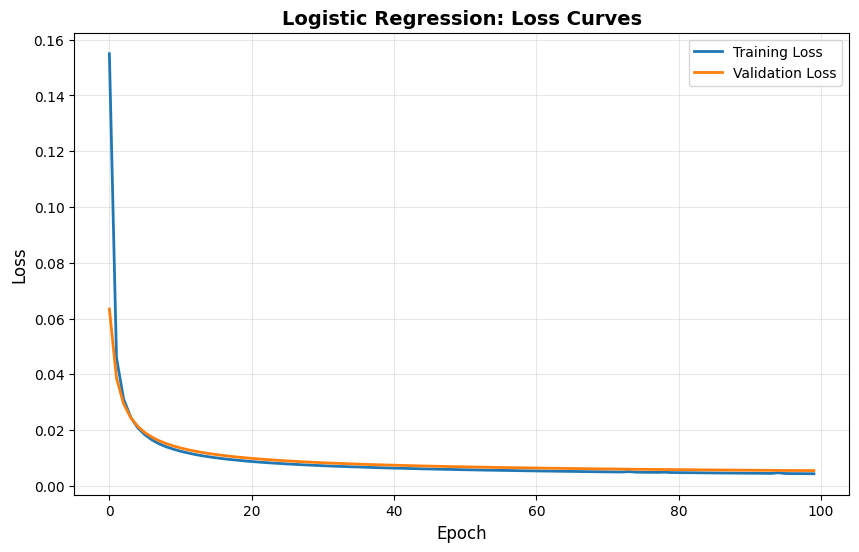

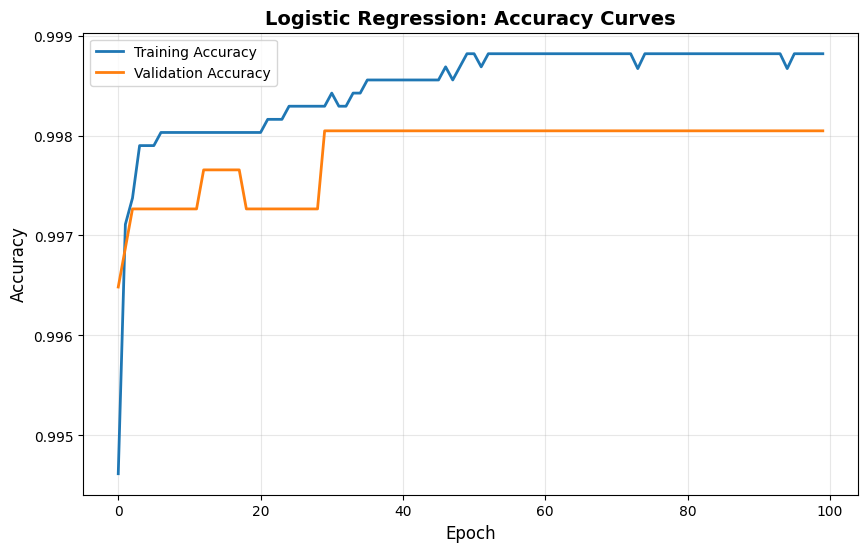

In [13]:
model.plot_curves()

## Test data

In [14]:
test_preds, _ = model.evaluate_test(X_test_flat_bin, y_test_bin)


Test Loss: 0.0070
Test Accuracy: 0.9976 (99.76%)


### Confusion Matrix

Confusion Matrix
[[1183    2]
 [   4 1344]]

True Negatives (0→0):  1183
False Positives (0→1): 2
False Negatives (1→0): 4
True Positives (1→1):  1344


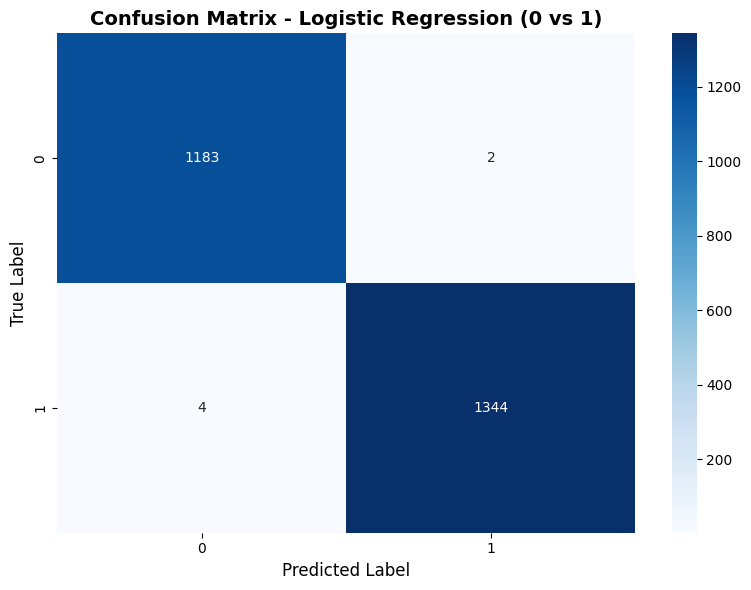

In [15]:
model.plot_confusion_matrix(y_test_bin, test_preds)

# 3. Softmax Regression Implementation


In [20]:
n_features = 28 * 28
n_classes = 10

model2 = SoftmaxRegression(input_dim=n_features, num_classes=n_classes,
                          learning_rate=0.05, max_epochs=100, patience=10)

model2.fit(train_loader_soft, val_loader_soft)

Epoch 10/100 - Train Loss: 0.2806, Train Acc: 0.9217 - Val Loss: 0.3067, Val Acc: 0.9155
Epoch 20/100 - Train Loss: 0.2624, Train Acc: 0.9269 - Val Loss: 0.2979, Val Acc: 0.9206
Epoch 30/100 - Train Loss: 0.2532, Train Acc: 0.9304 - Val Loss: 0.2935, Val Acc: 0.9203
Epoch 40/100 - Train Loss: 0.2474, Train Acc: 0.9320 - Val Loss: 0.2926, Val Acc: 0.9213

Early stopping triggered at epoch 47
Best validation loss: 0.2920 at epoch 37

Restored best model (Val Loss = 0.2920)


## Plot Loss and Accuracy

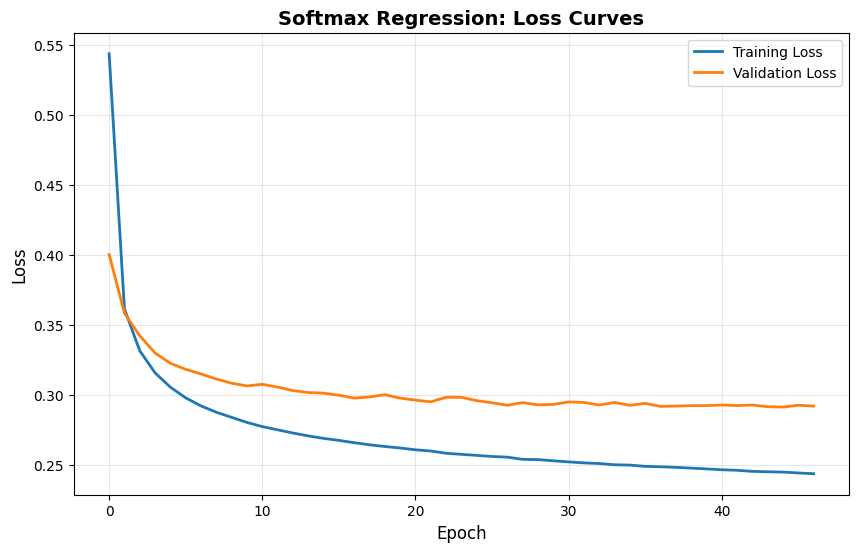

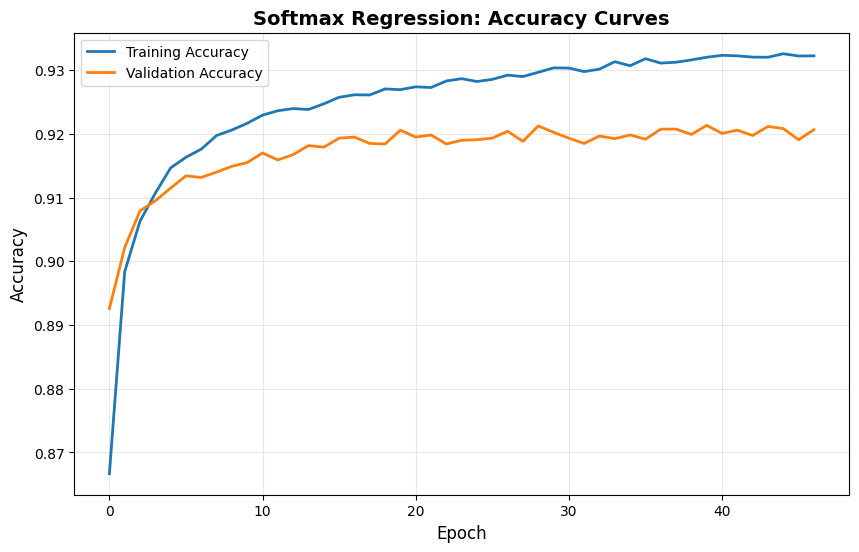

In [21]:
model2.plot_curves()

## Test Dataset

In [22]:
test_preds, test_probs = model2.evaluate_test(X_test_flat, y_test)


Test Loss: 0.2862
Test Accuracy: 0.9196 (91.96%)


## Confusion Matrix

Confusion Matrix
[[1142    0    7    4    4   15    6    1    3    2]
 [   0 1306    5    7    0    5    3    5   12    5]
 [   6   15 1080   19   11    5   23    8   21    4]
 [   7    4   25 1108    1   42    3    6   25    6]
 [   3    7   12    1 1064    1   11    1    5   64]
 [  14    8    7   41   14  936   16    4   28   16]
 [   9    3    9    0   10   18 1127    0    3    4]
 [   2   13   20    2    9    3    1 1157    3   43]
 [   8   28   18   33    5   29    6    2 1016   25]
 [   4    6    3   10   29    2    0   29    8 1099]]


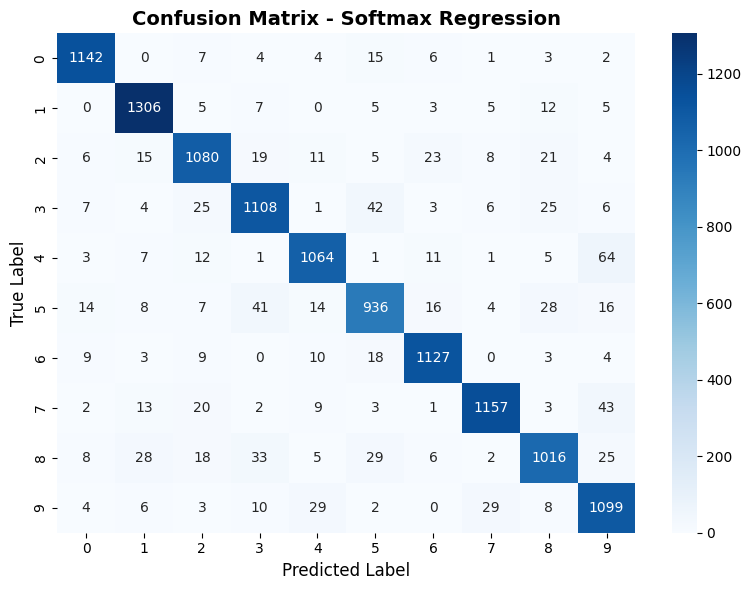

In [23]:
model2.plot_confusion_matrix(y_test, test_preds, class_labels=[str(i) for i in range(10)])
